In this notebook we clean the weather data collected from the [Climate Database Online](https://www.ncei.noaa.gov/cdo-web/search) compiled by NOAA. 

These datasets contain:
- Facility ID [STATION]: The station ID of the weather monitoring facility.
- Facility Name [NAME]: The name and state of the weather monitoring facility.
- Date [DATE]: The year and month of the measurement in YYYY-MM format.
- Rain [PRCP]: The amount of rain in inches measured at the facility.
- Snow Total [SNOW]: The aamount of snow in inches measured by the facility.

This notebook expects data to be stored in a directory `SharedData` at the root of the git repo. This directory should have the same structure as the `Data` folder stored on the project Google Drive.

In [1]:
# Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import the data
df1 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "AL-GA,OK,OR.csv"))
df2 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "HI-MN.csv"))
df3 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "MS-OH.csv"))
df4 = pd.read_csv(os.path.join("..", "..", "SharedData", "Weather (1990-2019)", "PA-WY.csv"))
df = pd.concat([df1, df2, df3, df4])
df.sample(5)

,STATION,NAME,DATE,PRCP,SNOW,TAVG
469,USW00023183,"PHOENIX AIRPORT, AZ US",1998-03,1.31,0.0,61.9
3617,USC00072730,"DOVER, DE US",2012-11,1.28,NaN,43.4
1720,USW00026528,"TALKEETNA AIRPORT, AK US",2009-07,1.61,NaN,62.6
1521,USW00014764,"PORTLAND JETPORT, ME US",1997-02,2.59,6.2,28.7
3229,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2011-04,3.06,0.0,65.3


In [3]:
# Check to see if we have 50 facilities:
len(df.STATION.unique())

50

In [4]:
# Extract state from facility name
df["state"] = df.NAME.str[-5:-3]
df.sample(5)

,STATION,NAME,DATE,PRCP,SNOW,TAVG,state
3218,USW00093730,"ATLANTIC CITY INTERNATIONAL AIRPORT, NJ US",2018-11,10.59,0.0,45.8,NJ
1078,USW00013743,"WASHINGTON REAGAN NATIONAL AIRPORT, VA US",2019-11,1.37,0.0,46.1,VA
603,USW00014933,"DES MOINES INTERNATIONAL AIRPORT, IA US",2010-04,4.69,0.0,58.7,IA
133,USW00024130,"BAKER CITY AIRPORT, OR US",2001-02,0.20,2.8,27.5,OR
1405,USC00516128,"MANOA LYON ARBO 785.2, HI US",2017-06,12.27,NaN,74.9,HI


In [5]:
len(df.state.unique())

50

In [6]:
# Rename columns to be more consistent
df = df.rename(columns={"DATE":"date", "PRCP":"prcp", "SNOW":"snow", "TAVG":"tavg"})
df.sample(5)

,STATION,NAME,date,prcp,snow,tavg,state
1338,USW00013967,"OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US",2008-08,9.95,0.0,81.0,OK
2680,USW00093037,"COLORADO SPRINGS MUNICIPAL AIRPORT, CO US",1996-07,4.47,NaN,69.8,CO
184,USW00013880,"CHARLESTON INTL. AIRPORT, SC US",2005-05,5.17,0.0,69.9,SC
1891,USW00014821,"JOHN GLENN INTERNATIONAL AIRPORT, OH US",1997-11,2.92,0.9,40.1,OH
221,USW00094847,"DETROIT METRO AIRPORT, MI US",2008-06,4.05,0.0,70.6,MI


In [7]:
# Verify no duplicate dates
abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
count = 0
for i in abbreviations:
    if len(df[df.state==i].date.unique()) != len(df[df.state==i]):
        print(i)
        count += 1
if not count:
    print("All dates are unique for each state!")

All dates are unique for each state!


In [8]:
# Some dates are missing though. Let's see how many and then fill them in
missing_count = 0

# We'll have to cluster to make this work:
state_date_dfs = [df[df.state==x].copy() for x in df.state.unique()]
state_date_dfs_fixed = []
for dfi in state_date_dfs:
    dfi.date = pd.to_datetime(dfi.date)
    dfi["date_index"] = dfi.date
    dfi = dfi.set_index("date_index")
    # Make sure date indices are not duplicated
    assert(len(dfi.index)==len(dfi.index.unique()))
    # Get the full range that should exist
    start_date = "1990-01-01"
    end_date = "2019-12-31"
    complete_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    # And print the difference
    missing_months = complete_range.difference(dfi.index)
    missing_count += len(missing_months)
    # Uncomment these to check which months are missing!
    # print(dfi.state.unique())
    # print(missing_months)
    dfi = dfi.reindex(complete_range)
    # Lastly, fill in the data that we know already here
    dfi.STATION = dfi.STATION.ffill()
    dfi.NAME = dfi.NAME.ffill()
    dfi.state = dfi.state.ffill()
    dfi.date = dfi.date.fillna(dfi.index.to_series())
    state_date_dfs_fixed.append(dfi)

print("Number of missing months:", missing_count)

# And finally put it all back together:
df = pd.concat(state_date_dfs_fixed).reindex()
df

Number of missing months: 26


,STATION,NAME,date,prcp,snow,tavg,state
1990-01-01,USW00024130,"BAKER CITY AIRPORT, OR US",1990-01-01,0.97,5.5,29.6,OR
1990-02-01,USW00024130,"BAKER CITY AIRPORT, OR US",1990-02-01,0.22,1.5,29.3,OR
1990-03-01,USW00024130,"BAKER CITY AIRPORT, OR US",1990-03-01,0.60,0.2,39.3,OR
1990-04-01,USW00024130,"BAKER CITY AIRPORT, OR US",1990-04-01,0.99,0.0,49.1,OR
1990-05-01,USW00024130,"BAKER CITY AIRPORT, OR US",1990-05-01,2.13,0.0,50.3,OR
...,...,...,...,...,...,...,...
2019-08-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2019-08-01,0.48,0.0,72.1,WA
2019-09-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2019-09-01,1.98,3.3,59.1,WA
2019-10-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2019-10-01,1.54,3.6,42.3,WA
2019-11-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2019-11-01,0.68,0.6,35.7,WA


A brief aside here--let's take a look at the NA values to try and better understand what needs cleaning.

In [9]:
# ACheck the number of NA values
df.isna().sum()

STATION       0
NAME          0
date          0
prcp         36
snow       1963
tavg         54
state         0
dtype: int64

In [10]:
# See the precipitation values
df[df.prcp.isna()]

,STATION,NAME,date,prcp,snow,tavg,state
2001-09-01,USW00024130,"BAKER CITY AIRPORT, OR US",2001-09-01,NaN,NaN,NaN,OR
1995-10-01,USW00026528,"TALKEETNA AIRPORT, AK US",1995-10-01,NaN,NaN,NaN,AK
2005-12-01,USC00072730,"DOVER, DE US",2005-12-01,NaN,NaN,NaN,DE
2009-02-01,USC00072730,"DOVER, DE US",2009-02-01,NaN,NaN,NaN,DE
2009-03-01,USC00072730,"DOVER, DE US",2009-03-01,NaN,NaN,NaN,DE
2011-11-01,USC00072730,"DOVER, DE US",2011-11-01,NaN,NaN,51.9,DE
2014-01-01,USC00072730,"DOVER, DE US",2014-01-01,NaN,NaN,31.5,DE
2014-12-01,USC00072730,"DOVER, DE US",2014-12-01,NaN,0.0,41.7,DE
2012-05-01,USC00120784,"BLOOMINGTON INDIANA UNIVERSITY, IN US",2012-05-01,NaN,0.0,69.0,IN
2019-08-01,USC00120784,"BLOOMINGTON INDIANA UNIVERSITY, IN US",2019-08-01,NaN,0.0,NaN,IN


In [11]:
# And see the NA snow values
# There's a lot here! Clearly snow values are not standardized.
df[df.snow.isna()]

,STATION,NAME,date,prcp,snow,tavg,state
2000-09-01,USW00024130,"BAKER CITY AIRPORT, OR US",2000-09-01,2.02,NaN,54.0,OR
2001-09-01,USW00024130,"BAKER CITY AIRPORT, OR US",2001-09-01,NaN,NaN,NaN,OR
2001-10-01,USW00024130,"BAKER CITY AIRPORT, OR US",2001-10-01,0.61,NaN,44.0,OR
2001-11-01,USW00024130,"BAKER CITY AIRPORT, OR US",2001-11-01,0.80,NaN,36.6,OR
2001-12-01,USW00024130,"BAKER CITY AIRPORT, OR US",2001-12-01,0.95,NaN,24.3,OR
...,...,...,...,...,...,...,...
1997-07-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",1997-07-01,0.80,NaN,67.5,WA
1997-08-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",1997-08-01,0.14,NaN,70.9,WA
1997-09-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",1997-09-01,0.92,NaN,61.9,WA
1997-10-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",1997-10-01,1.67,NaN,47.2,WA


In [12]:
# Here, check the number of NA snow values by state
# Then normalize to years -- I want to know just how big a chunk of data is missing here
df[df.snow.isna()].groupby("state").agg({"snow": lambda x: x.isna().sum() / 12})

,snow
state,
AK,22.083333
AL,8.583333
AR,2.083333
AZ,19.916667
CA,23.000000
CO,0.583333
CT,0.500000
DE,3.833333
FL,13.000000


In [13]:
# And see the NA temperature averages values
df[df.tavg.isna()].sort_values("date")

,STATION,NAME,date,prcp,snow,tavg,state
1990-05-01,USC00072730,"DOVER, DE US",1990-05-01,7.81,0.0,NaN,DE
1991-07-01,USC00102942,"EMMETT 2 E, ID US",1991-07-01,NaN,0.0,NaN,ID
1992-08-01,USC00516128,"MANOA LYON ARBO 785.2, HI US",1992-08-01,NaN,NaN,NaN,HI
1992-11-01,USC00072730,"DOVER, DE US",1992-11-01,2.93,0.0,NaN,DE
1994-03-01,USC00516128,"MANOA LYON ARBO 785.2, HI US",1994-03-01,27.44,0.0,NaN,HI
1995-02-01,USW00014916,"GRAND FORKS INTERNATIONAL AIRPORT, ND US",1995-02-01,NaN,NaN,NaN,ND
1995-10-01,USW00026528,"TALKEETNA AIRPORT, AK US",1995-10-01,NaN,NaN,NaN,AK
1995-10-01,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",1995-10-01,NaN,NaN,NaN,NE
1995-11-01,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",1995-11-01,NaN,NaN,NaN,NE
1995-12-01,USW00014942,"OMAHA EPPLEY AIRFIELD, NE US",1995-12-01,NaN,NaN,NaN,NE


Average temperatures occasionally come in sets of two or three consecutive months. But on the whole, the missing temperature values appear scattered. So it appears to me to be reasonable to fill them in by interpolation over the surrounding months.

Meanwhile, precipitation is only missing a handful of data points. Snow is missing far more. For now, I just set these to zero.

Now resume cleaning the dataset.

In [14]:
# Now sort the values by state and date
df = df.sort_values(["state", "date"])
# When there are no snow measurements, assume no snow for now
# There is a LOT of missing snow data, maybe too much to impute.
df.snow = df.snow.fillna(0)
# It's not reasonable to handwave temperature away, 
# so interpolate over these values instead
# This simple approach MAY not be sufficient. May need to check:
#  (a) that linear interpolation is sufficient
#  (b) that this doesn't need to be done on a state-by-state basis
#      in order to prevent one state from affecting another's empty value
#df.tavg = df.tavg.interpolate(method="linear")

In [15]:
# For rain, impute the value based on the average from the same month in the adjacent years
# This process involves:
#  (1) clustering the data according to states
#  (2) reindexing the data according to the date
#  (3) creating columns to shift the data by a year in either direction. 
#       - Use freq="MS" (month start) in order to maintain compatibility with the rest of the data
#  (4) Either taking the average of two years or just taking the value of one year depending on what is available
# Print out the leftover NA PRCP values. There should be zero.

# It's not reasonable to handwave temperature away, 
# so interpolate over these values instead
# This simple approach MAY not be sufficient. May need to check:
#  (a) that linear interpolation is sufficient
#  (b) that this doesn't need to be done on a state-by-state basis
#      in order to prevent one state from affecting another's empty value

state_dfs = [df[df.state==x].copy() for x in df.state.unique()]
state_dfs_shifted = []
for dfi in state_dfs:
    # Reindex
    dfi.date = pd.to_datetime(dfi.date)
    dfi = dfi.set_index("date")
    #dfi = dfi.index.rename("dateid")
    # Impute
    dfi["prcp_minus"] = dfi.prcp.shift(-12, freq="MS")
    dfi["prcp_plus"] = dfi.prcp.shift(12, freq="MS")
    dfi.prcp = dfi.prcp.fillna((dfi.prcp_minus + dfi.prcp_plus) / 2.0)
    dfi.prcp = dfi.prcp.fillna(dfi.prcp_minus)
    dfi.prcp = dfi.prcp.fillna(dfi.prcp_plus)
    # Interpolate
    dfi.tavg = dfi.tavg.interpolate(method="linear")
    state_dfs_shifted.append(dfi)
shifted_df = pd.concat(state_dfs_shifted)
print("Number of zero precipitation elements:", len(shifted_df[shifted_df.prcp.isna()]))
print("Number of zero temperature elements:", len(shifted_df[shifted_df.tavg.isna()]))
shifted_df

Number of zero precipitation elements: 0
Number of zero temperature elements: 0


,STATION,NAME,prcp,snow,tavg,state,prcp_minus,prcp_plus
date,,,,,,,,
1990-01-01,USW00026528,"TALKEETNA AIRPORT, AK US",3.63,60.2,9.3,AK,2.34,NaN
1990-02-01,USW00026528,"TALKEETNA AIRPORT, AK US",4.31,60.3,-4.2,AK,0.63,NaN
1990-03-01,USW00026528,"TALKEETNA AIRPORT, AK US",3.94,43.7,26.8,AK,3.29,NaN
1990-04-01,USW00026528,"TALKEETNA AIRPORT, AK US",0.93,2.1,38.1,AK,1.02,NaN
1990-05-01,USW00026528,"TALKEETNA AIRPORT, AK US",1.61,0.0,49.2,AK,1.05,NaN
...,...,...,...,...,...,...,...,...
2019-08-01,USW00024089,"CASPER NATRONA CO AIRPORT, WY US",0.17,0.0,69.7,WY,NaN,0.33
2019-09-01,USW00024089,"CASPER NATRONA CO AIRPORT, WY US",1.42,0.0,61.4,WY,NaN,0.28
2019-10-01,USW00024089,"CASPER NATRONA CO AIRPORT, WY US",1.30,13.9,36.9,WY,NaN,1.69


In [16]:
# If we're happy with the above, we can replace the dataset wholesale
df = shifted_df
#df["date"] = shifted_df.index.strftime('%Y-%m')
print("Number of states in the final dataset:", len(shifted_df.state.unique()))
df.sample()

Number of states in the final dataset: 50


,STATION,NAME,prcp,snow,tavg,state,prcp_minus,prcp_plus
date,,,,,,,,
1996-02-01,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2.93,0.0,28.7,WA,1.4,1.6


In [17]:
# And now verify there are no other NA values
# (We don't care about prcp_plus and prcp_minus -- they served their purpose)
df.isna().sum()

STATION         0
NAME            0
prcp            0
snow            0
tavg            0
state           0
prcp_minus    636
prcp_plus     634
dtype: int64

In [18]:
# Write out a new CSV file, sorted by state and date
features = ["state", "prcp", "snow", "tavg"]
new_df = df[features].sort_values(["state", "date"])
new_df.to_csv("monthly-weather-1990-2019-final.csv", date_format='%Y-%m')
print("Number of states in the final dataset:", len(new_df.state.unique()))

Number of states in the final dataset: 50


Finally, make some plots of these features to make sure they make sense. This should also expose any non-numeric values that may have snuck past.

Text(0, 0.5, 'Precipitation (in)')

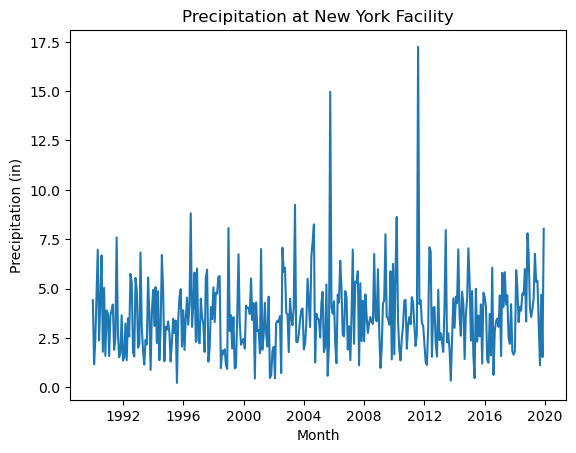

In [19]:
plt.plot(new_df[new_df.state=="NY"].index.date, new_df[new_df.state=="NY"].prcp)
plt.title("Precipitation at New York Facility")
plt.xlabel("Month")
plt.ylabel("Precipitation (in)")

Text(0, 0.5, 'Snow (in)')

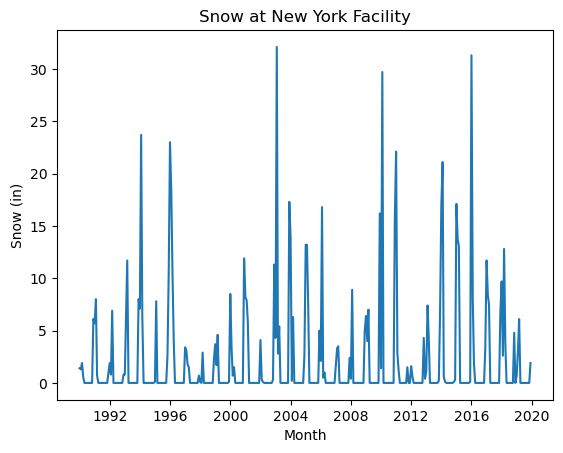

In [20]:
plt.plot(new_df[new_df.state=="NY"].index.date, new_df[new_df.state=="NY"].snow)
plt.title("Snow at New York Facility")
plt.xlabel("Month")
plt.ylabel("Snow (in)")

Text(0, 0.5, 'Temperature (degrees Fahrenheit)')

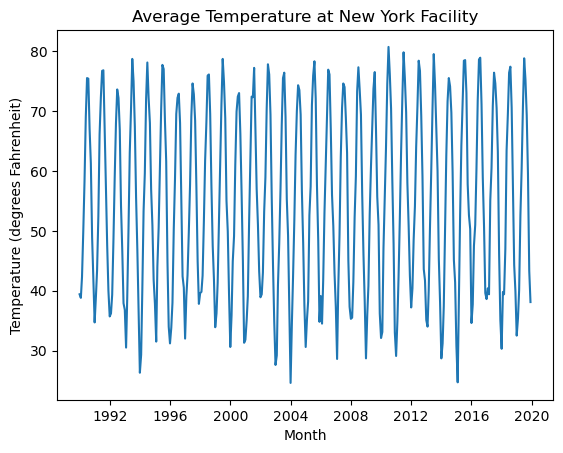

In [21]:
plt.plot(new_df[new_df.state=="NY"].index.date, new_df[new_df.state=="NY"].tavg)
plt.title("Average Temperature at New York Facility")
plt.xlabel("Month")
plt.ylabel("Temperature (degrees Fahrenheit)")

Now check another state that is not New York for comparison.

In [22]:
full_names = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
    "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

def check_state(state_abbrev):
    #plt.title("Precipitation at New York Facility")
    #plt.xlabel("Month")
    #plt.ylabel("Precipitation (in)")

    plt.rcParams['text.usetex'] = True

    # Information on doing this here: 
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/ganged_plots.html
    fig, axs = plt.subplots(3, 1, sharex=True)
    fig.subplots_adjust(hspace=0)
    fig.set_size_inches((10,6))

    df_plot = new_df[new_df.state==state_abbrev]
    x = df_plot.index.date

    axs[0].plot(x, df_plot.prcp)
    axs[0].set_title(f"Weather Data for {full_names[abbreviations.index(state_abbrev)]}")
    axs[0].set_ylabel("Total Monthly\nPrecipitation (in)")

    axs[1].plot(x, df_plot.snow)
    axs[1].set_ylabel("Total Monthly\nSnow (in)")

    axs[2].plot(x, df_plot.tavg)
    axs[2].set_ylabel("Average Monthly\nTemperature ($^\\circ$F)")

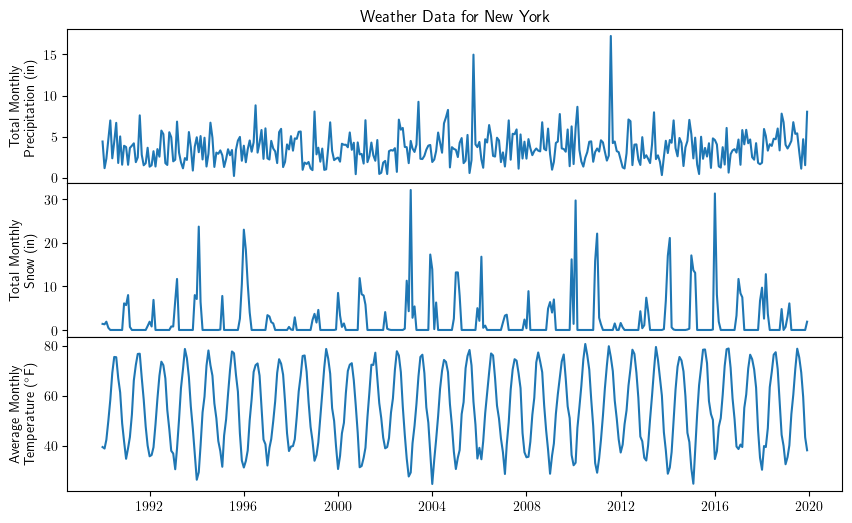

In [23]:
check_state("NY")

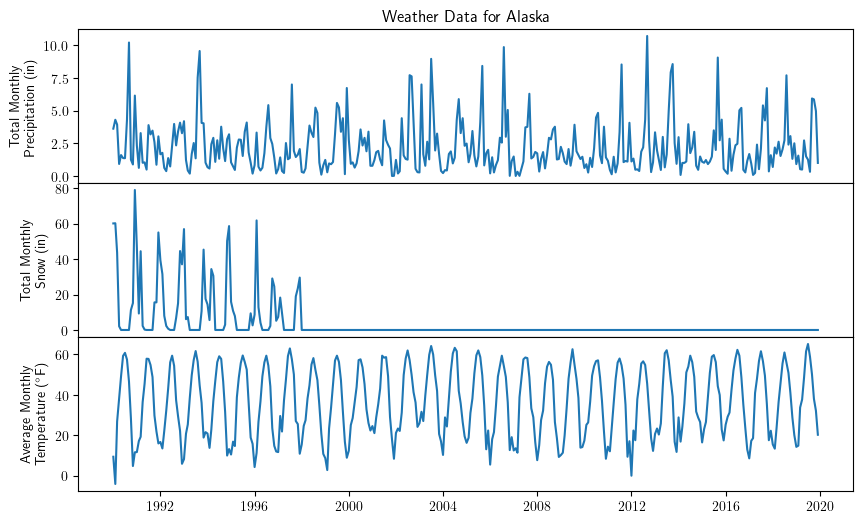

In [24]:
check_state("AK")

As suspected from earlier analysis, we're missing huge chunks of Alaska snow here, and it seems unlikely that Alaska simply stopped receiving snow.

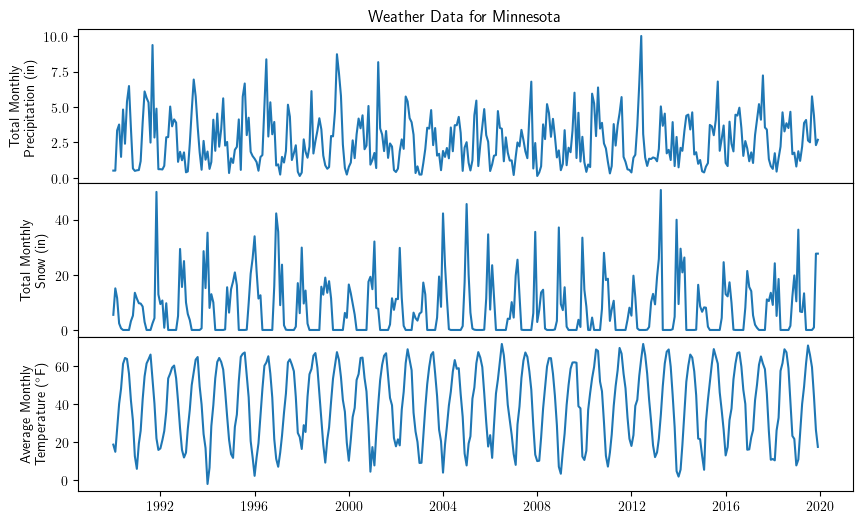

In [25]:
check_state("MN")

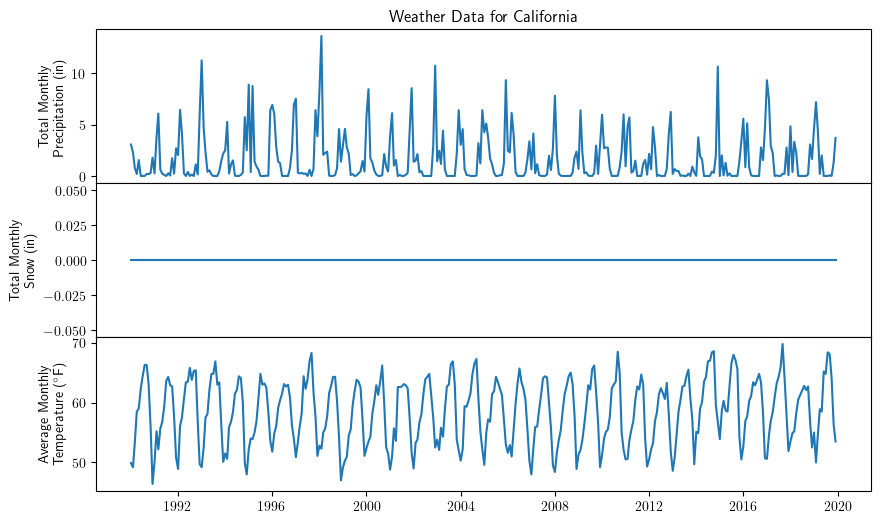

In [26]:
check_state("CA")

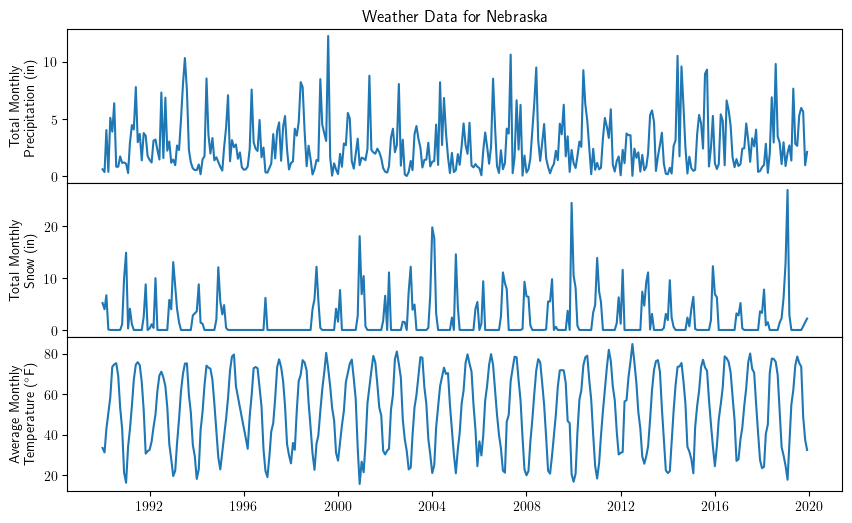

In [27]:
check_state("NE")